Simulation Project 1:
Using SPSA（Simultaneous Perturbation Stochastic Approximation） method to find the best invesment strategy.


In [1]:
# import libraries
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt

In [2]:
# Define the parameters and functions
rho = 0.6  # Correlation coefficient
p_0 = np.array([0.2, 0.1])  # Initial p1 and p2
x = np.array([2, 3, 1])  # thresholds for the three assets
i_values = [1, 2, 3]  # Variances of ita_i
num_iterations = 1000  # Number of simulation iterations for G1, G2, G3


# Initialize arrays to store X1, X2, X3
X1, X2, X3 = np.zeros(num_iterations), np.zeros(num_iterations), np.zeros(num_iterations)
Y1, Y2, Y3 = np.zeros(num_iterations), np.zeros(num_iterations), np.zeros(num_iterations)
#Gi means the gain from investing the ith firm.
G1, G2, G3 = np.zeros(num_iterations), np.zeros(num_iterations), np.zeros(num_iterations)
Sharpes = np.zeros(num_iterations)

# Generate multiple samples of V and W
V_samples = np.random.normal(loc=0.0, scale=1.0, size=num_iterations)
W_samples = np.random.exponential(scale=1/0.3, size=num_iterations)

In [3]:
num_SPSA_iterations = 100  # Number of iterations for SPSA

In [4]:
# Do you want to use decreasing or fixed epsilon?
EPSILON_TYPE = 'decreasing' #'fixed' or 'decreasing'
# Fill in the value for epsilon. The decreasing epsilon uses the form EPSILON_VALUE/(i+1).
EPSILON_VALUE = 0.05

In [5]:
# Adds normally distributed noise to the objective function. 
def add_noise(MU, SIGMA, rng_noise):
    return rng_noise.normal(MU, SIGMA)

In [6]:
# Which seed do you want to use?
SEED = 10

In [7]:
# Do you want to add stochasticity?
STOCHASTIC = False #False or True
MU = 0 # mu parameter of the normal distribution for the noise.
SIGMA = 1 # sigma parameter of the normal distribution for the noise.
NOISE_SEED = 0 # Seed for the added noise. SEED and NOISE_SEED should NOT have the same value.
rng_noise = np.random.default_rng(NOISE_SEED)
rng = np.random.default_rng(SEED)
# In case of stochasticity, do you want to estimate the gradient multiple times and use the average as update?
BATCH = True #False or True
NR_ESTIMATES = 10 # Number of estimates to average over.

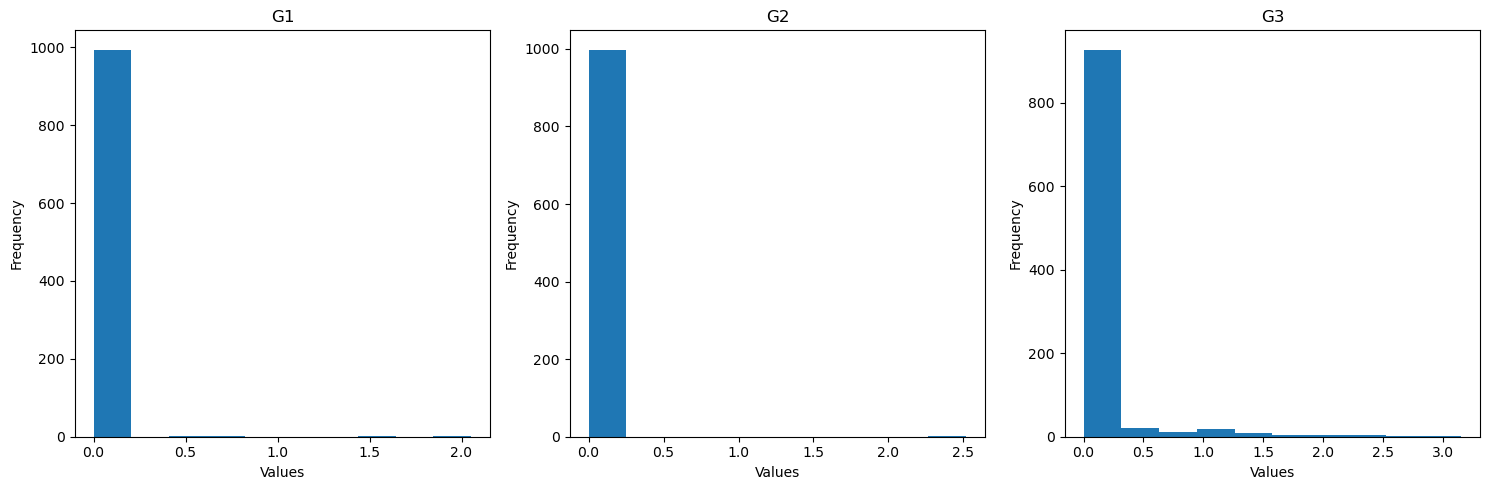

In [8]:
# Simulate the G1, G2, G3 values
for i in range(num_iterations):
    V = V_samples[i]
    W = W_samples[i]
    
    # Generate ita1, ita2, ita3
    ita1, ita2, ita3 = np.random.normal(loc=0.0, scale=np.sqrt(i_values[0]), size=1), \
                       np.random.normal(loc=0.0, scale=np.sqrt(i_values[1]), size=1), \
                       np.random.normal(loc=0.0, scale=np.sqrt(i_values[2]), size=1)
    
    # Calculate X1, X2, X3, Y1, Y2, Y3, G1, G2, G3
    X1[i] = (rho * V + 0.8 * ita1) / np.maximum(W, 1)
    X2[i] = (rho * V + 0.8 * ita2) / np.maximum(W, 1)
    X3[i] = (rho * V + 0.8 * ita3) / np.maximum(W, 1)
    Y1[i] = np.random.uniform(low=0, high=X1[i])
    Y2[i] = np.random.uniform(low=0, high=X2[i])
    Y3[i] = np.random.uniform(low=0, high=X3[i])
    if X1[i] > x[0]:
        G1[i] = Y1[i]
    else:
        G1[i] = 0

    if X2[i] > x[1]:
        G2[i] = Y2[i]
    else:
        G2[i] = 0

    if X3[i] > x[2]:
        G3[i] = Y3[i]
    else:
        G3[i] = 0   

'''# Print the results
print("G1:", G1)
print("G2:", G2)
print("G3:", G3)
print("X1 mean:", np.mean(X1))
print("X2 mean:", np.mean(X2))
print("X3 mean:", np.mean(X3))
print("Y1 mean:", np.mean(Y1))
print("Y2 mean:", np.mean(Y2))
print("Y3 mean:", np.mean(Y3))
'''
# Plot the histograms of G1, G2, G3
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].set_title('G1')
axs[0].set_xlabel('Values')
axs[0].set_ylabel('Frequency')
axs[0].hist(G1)

axs[1].set_title('G2')
axs[1].set_xlabel('Values')
axs[1].set_ylabel('Frequency')
axs[1].hist(G2)

axs[2].set_title('G3')
axs[2].set_xlabel('Values')
axs[2].set_ylabel('Frequency')
axs[2].hist(G3)

# Display the plots
plt.tight_layout()  # Adjust the plots to fit into the figure area
plt.show()

In [9]:
def sharpe_ratio(Sharpes,p, G1 ,G2 ,G3,num_iterations,MU, SIGMA, rng_noise):
    for i in range(num_iterations):
        Sharpes[i] = p[0] * G1[i] + p[1] * G2[i] + (1 - p[0] - p[1]) * G3[i]
    Sharperatio = np.mean(Sharpes) / np.std(Sharpes)
    if STOCHASTIC:
        noise =  add_noise(MU, SIGMA, rng_noise)
        Sharperatio = np.mean(Sharpes) / np.std(Sharpes) + noise
    return Sharperatio

#print(sharpe_ratio(Sharpes, p_0, G1 ,G2 ,G3,num_iterations,MU, SIGMA, rng_noise))

In [10]:
def estimate_gradient(p, i,  MU, SIGMA,BATCH, NR_ESTIMATES, rng, rng_noise):
    delta_i = rng.choice((-1, 1), size = len(p))
    eta_i = 1/(i+1)
    
    if BATCH:
        gradient_estimates = np.zeros((NR_ESTIMATES, len(p)))
        for n in range(NR_ESTIMATES): 
            delta_i = rng.choice((-1, 1), size = len(p)) #add this

            perturbation_high = p + eta_i*delta_i
            perturbation_low = p - eta_i*delta_i
            obj_perturbation_high = sharpe_ratio(Sharpes,perturbation_high, G1 ,G2 ,G3,num_iterations,MU, SIGMA, rng_noise)
            obj_perturbation_low = sharpe_ratio(Sharpes,perturbation_low, G1 ,G2 ,G3,num_iterations,MU, SIGMA, rng_noise)
            numerator = obj_perturbation_high-obj_perturbation_low
            denominator = 2*eta_i*delta_i
            gradient_estimates[n] = np.divide(numerator, denominator)
        gradient_estimate = np.mean(gradient_estimates, axis=0)
    else:
        perturbation_high = p + eta_i*delta_i
        perturbation_low = p - eta_i*delta_i
        obj_perturbation_high = sharpe_ratio(Sharpes,perturbation_high, G1 ,G2 ,G3,num_iterations,MU, SIGMA, rng_noise)
        obj_perturbation_low = sharpe_ratio(Sharpes,perturbation_low, G1 ,G2 ,G3,num_iterations,MU, SIGMA, rng_noise)
        numerator = obj_perturbation_high-obj_perturbation_low
        denominator = 2*eta_i*delta_i
        gradient_estimate = np.divide(numerator, denominator)
                                  
    return gradient_estimate

In [11]:
# The SPSA algorithm
def SPSA(SEED, NOISE_SEED, p_0, EPSILON_TYPE, EPSILON_VALUE, num_SPSA_iterations, STOCHASTIC, MU, SIGMA, BATCH, NR_ESTIMATES):
    rng = np.random.default_rng(SEED)
    rng_noise = np.random.default_rng(NOISE_SEED)
    ps = np.zeros((num_SPSA_iterations+1, len(p_0)))
    gradients = np.zeros((num_SPSA_iterations, len(p_0)))
    Sharperatios = np.zeros(num_SPSA_iterations+1)
    ps[0] = p_0
    Sharperatios[0] = sharpe_ratio(Sharpes, p_0, G1 ,G2 ,G3,num_iterations,MU, SIGMA, rng_noise)

    for i in range(num_SPSA_iterations):
        g = estimate_gradient(ps[i], i,  MU, SIGMA, BATCH, NR_ESTIMATES, rng, rng_noise)
        gradients[i] = g
        if EPSILON_TYPE == 'fixed':
            ps[i+1] = ps[i] + EPSILON_VALUE * g
        elif EPSILON_TYPE == 'decreasing':
            ps[i+1] = ps[i] + EPSILON_VALUE/(i+1) * g
        Sharperatios[i+1] = sharpe_ratio(Sharpes, ps[i+1], G1 ,G2 ,G3,num_iterations,MU, SIGMA, rng_noise)
        
    return ps, gradients, Sharperatios, rng_noise

In [12]:
# Plot the iterates and objective values during the optimisation
def plot_iterate_Sharperatio_gradient(ps, gradients, Sharperatios, STOCHASTIC, MU, SIGMA, rng_noise):
    
    if ps.shape[1] == 2:
        #2-dimensional plots.
        fig, axs = plt.subplots(2,2, figsize=(10,10))

        # Plot the iterate
        axs[0,0].plot(ps.T[0], color="darkblue", label = r'$p_1$')
        axs[0,0].plot(ps.T[1], color="deepskyblue", label = r'$p_2$')
        final_p1 = ps.T[0][-1]
        final_p2 = ps.T[1][-1]
 
        x_min, x_max = axs[0,0].get_xlim()  # Get the current x-axis range

        # Add points and dashed lines representing the final values
        # Assuming we want to add these lines to the right side of the plot
        axs[0,0].plot(ps.shape[0]-1, final_p1, 'o', color="darkblue", markersize=3)  # Final value point for p1
        axs[0,0].plot(ps.shape[0]-1, final_p2, 'o', color="deepskyblue", markersize=3)  # Final value point for p2

        # Alternatively, if you want to use the plot function and ensure the lines extend to the maximum value of the x-axis
        axs[0,0].axhline(y=final_p1, linestyle='--', color="darkblue")
        axs[0,0].axhline(y=final_p2, linestyle='--', color="deepskyblue")

        axs[0,0].set_xlabel("Iteration")
        axs[0,0].set_ylabel(r"$p_n$")
        axs[0,0].set_title(r"$p_n$ vs. Iteration")  # Consider modifying the title to better reflect the plot
        axs[0,0].legend()       

        # plot contour
        r=1
        x = np.linspace(0, r, 5)
        y = np.linspace(0, r, 5)

        X, Y = np.meshgrid(x, y)
        Z = np.array([[ sharpe_ratio(Sharpes,[X[i,j], Y[i,j]], G1 ,G2 ,G3,num_iterations,0, 1, rng_noise) for j in range(len(x))] for i in range(len(x))])

        CS = axs[0,1].contour(X, Y, Z)
        axs[0,1].clabel(CS, inline=1, fontsize=10)

        axs[0,1].plot(ps.T[0], ps.T[1], c="red", linewidth=1, label = r"$p_n$")
        axs[0,1].set_xlim(0,r)
        axs[0,1].set_ylim(0,r)
        axs[0,1].set_xlabel(r"$p_1$")
        axs[0,1].set_ylabel(r"$p_2$") 
        
        # Plot the objective values
        axs[1,0].plot( Sharperatios, color="darkblue")
        axs[1,0].set_xlabel("Iteration")
        axs[1,0].set_ylabel(r"Sharperatio($p_n$)")
        axs[1,0].set_title(r"Sharperatio($p_n$)")

        # Plot the estimated gradients
        axs[1,1].plot(gradients.T[0], color="darkblue", label = r'$g^{SPSA}_1$')
        axs[1,1].plot(gradients.T[1], color="deepskyblue", label = r'$g^{SPSA}_2$')
        axs[1,1].set_xlabel("Iteration")
        axs[1,1].set_ylabel(r"$g^{SPSA}$($p_n$)")
        axs[1,1].set_title(r"$g^{SPSA}$($p_n$)")
        axs[1,1].legend()
        
    else:
        #N-dimensional plots.
        fig, axs = plt.subplots(1,3, figsize=(15,5))

        # Plot the iterate
        for i in range(ps.shape[1]):
            axs[0].plot(ps.T[i], label = rf'$p_{i}$')
        axs[0].set_xlabel("Iteration")
        axs[0].set_ylabel(r"$p_n$")
        axs[0].set_title(r"$p_n$")
        axs[0].legend()

        # Plot the objective values
        axs[1].plot(Sharperatios, color="darkblue")
        axs[1].set_xlabel("Iteration")
        axs[1].set_ylabel(r"Sharperatio($p_n$)")
        axs[1].set_title(r"Sharperatio($p_n$)")

        # Plot the estimated gradients
        for i in range(ps.shape[1]):
            axs[2].plot(gradients.T[i], label = rf'$g^{{SPSA}}_{i}$')
        axs[2].set_xlabel("Iteration")
        axs[2].set_ylabel(r"$g^{SPSA}$($p_n$)")
        axs[2].set_title(r"$g^{SPSA}$($p_n$)")
        axs[2].legend()


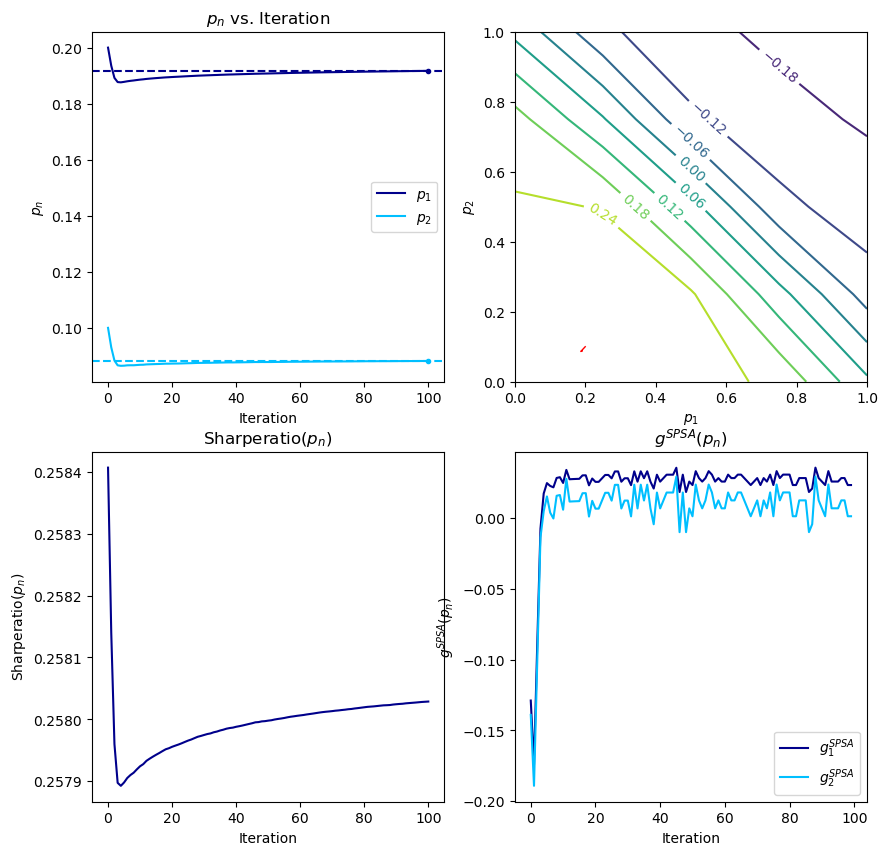

In [13]:
# Run SPSA and plot the optimisation
ps, gradients, Sharperatios, rng_noise= SPSA(SEED, NOISE_SEED, p_0, EPSILON_TYPE, EPSILON_VALUE, num_SPSA_iterations, STOCHASTIC, MU, SIGMA, BATCH, NR_ESTIMATES)
plot_iterate_Sharperatio_gradient(ps, gradients, Sharperatios, STOCHASTIC, MU, SIGMA, rng_noise)

In [14]:
final_p1 = ps.T[0][-1]
final_p2 = ps.T[1][-1]
final_p3 = 1 - final_p1 - final_p2
print("The optimal allocation vector is: ( " + str(final_p1) + ", " + str(final_p2) + ", " + str(final_p3) + " )")



The optimal allocation vector is: ( 0.19171319623611055, 0.08816960797874304, 0.7201171957851464 )
